In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from torch.utils.data import DataLoader, TensorDataset

np.random.seed(1337)

# Load and process the data
aggregate_df1 = pd.read_csv('/home/awinlab/Documents/kevin/elec220.csv', index_col='datetime', parse_dates=True)
aggregate_df1 = aggregate_df1[:900000]

plug1_1 = pd.read_csv('/home/awinlab/Documents/kevin/plug3-3.csv', index_col='datetime', parse_dates=True)
plug1_1 = plug1_1[:900000]

aggregate_df1 = aggregate_df1.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'], axis=1)
plug1_1 = plug1_1.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'], axis=1)

/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, length=100):
        self.X = X
        self.y = y
        self.length = length

    def __len__(self):
        return len(self.X) - self.length

    def __getitem__(self, idx):
        X = self.X[idx: idx + self.length]
        y = self.y[idx: idx + self.length]
        return X, y

mask = [i % 5 != 0 for i in range(len(aggregate_df1))]
X_train = aggregate_df1[~np.array(mask)]
X_test = aggregate_df1[mask]



mask1 = [i % 5 != 0 for i in range(len(plug1_1))]
y_train = plug1_1[~np.array(mask1)]
y_test = plug1_1[mask1]

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)


X_train = torch.tensor(X_train.values).float()
X_test = torch.tensor(X_test.values).float()
y_train = torch.tensor(y_train.values).float()
y_test = torch.tensor(y_test.values).float()


In [4]:
batch_size=60

train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers = 0, drop_last = True, 
                                           collate_fn=lambda x: (torch.nn.utils.rnn.pad_sequence([i[0] for i in x], batch_first=True),
                                                                 torch.nn.utils.rnn.pad_sequence([i[1] for i in x], batch_first=True)))

test_dataset = TimeSeriesDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers = 0, drop_last = True,
                                           collate_fn=lambda x: (torch.nn.utils.rnn.pad_sequence([i[0] for i in x], batch_first=True),
                                                                 torch.nn.utils.rnn.pad_sequence([i[1] for i in x], batch_first=True)))

In [5]:
import torch.nn.functional as F
from torch.nn import L1Loss

class ConvolutionalModel(nn.Module):
    def __init__(self, input_shape, n_input):
        super().__init__()
        self.pad = nn.ConstantPad1d((1, 2), 0)
        self.conv = nn.Conv1d(100, 16, 4, stride = 1)
        self.lstm_1 = nn.LSTM(input_size = 16, hidden_size = 64, batch_first = True, bidirectional = True)
        self.lstm_2 = nn.LSTM(input_size = 2*64, hidden_size = 128, batch_first = True, bidirectional = True)
        self.fc_1 = nn.Linear(128 * 2,128)
        self.fc_2 = nn.Linear(128,1)
        self.act = nn.Tanh() 
        
    def forward(self, x):
        padded_x = self.pad(x)
        conved_x = self.conv(padded_x).permute(0,2,1)
        lstm_out_1,_ = self.lstm_1(conved_x)
        lstm_out_2,_ = self.lstm_2(lstm_out_1)
        out = self.fc_2(self.act(self.fc_1(lstm_out_2.contiguous().view(x.size(0), -1))))
        return out

n_input = 100
input_shape = (n_input, 1)
model = ConvolutionalModel(input_shape, n_input)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)
mae_fn = nn.L1Loss()

model = model.to(device)
loss_fn = loss_fn.to(device)
mae_fn = mae_fn.to(device)

In [6]:
def rete(y_true, y_pred):
    y_true = y_true.view(-1, 1)
    y_pred = y_pred.view(-1, 1)

    # Compute the maximum value between y_true and y_pred element-wise, and reshape it to have shape (batch_size*seq_len, 1)
    max_val, _ = torch.max(torch.cat([y_pred, y_true], dim=1), dim=1, keepdim=True)

    # Compute the relative error between y_true and y_pred element-wise, and reshape it to have shape (batch_size*seq_len, 1)
    rel_err = torch.abs(y_pred - y_true) / max_val

    # Take the mean of the relative error across all samples in the batch
    return torch.mean(rel_err)

In [7]:

import matplotlib.pyplot as plt
import tqdm



num_epochs = 5

for epoch in range(num_epochs):
    for i, (X_batch, y_batch) in enumerate(tqdm.tqdm(train_loader)):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch) 
        loss = loss_fn(y_pred.view(-1), y_batch.view(-1,1))
        mae = mae_fn(y_pred.view(-1), y_batch.view(-1,1))
        rete_val = rete(y_batch[:,0,:].view(-1,1), y_pred.view(-1,1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    tqdm.tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item()}, MAE: {mae.item()}, Rete: {rete_val.item()}")


  0%|          | 0/2998 [00:00<?, ?it/s]/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([6000, 1])) that is different to the input size (torch.Size([60])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([6000, 1])) that is different to the input size (torch.Size([60])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 2998/2998 [00:19<00:00, 154.85it/s]


Epoch [1/5], Step [2997/2998], Loss: 0.014365890063345432, MAE: 0.1198577955365181, Rete: 0.004794311709702015


100%|██████████| 2998/2998 [00:19<00:00, 153.66it/s]


Epoch [2/5], Step [2997/2998], Loss: 0.002693105721846223, MAE: 0.0518951378762722, Rete: 0.002075805561617017


100%|██████████| 2998/2998 [00:19<00:00, 156.18it/s]


Epoch [3/5], Step [2997/2998], Loss: 3.146769813611172e-05, MAE: 0.005609607789665461, Rete: 0.00022433398407883942


100%|██████████| 2998/2998 [00:19<00:00, 153.82it/s]


Epoch [4/5], Step [2997/2998], Loss: 0.0005205563502386212, MAE: 0.022815704345703125, Rete: 0.0009117961162701249


100%|██████████| 2998/2998 [00:18<00:00, 165.97it/s]

Epoch [5/5], Step [2997/2998], Loss: 0.0005330767598934472, MAE: 0.023088455200195312, Rete: 0.0009226861293427646


In [8]:
predict = []
model = model.cpu()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predict.append(outputs)
        
predict_list = np.concatenate([p.detach().numpy() for p in predict], axis=0)

In [9]:
predict_list.shape

(719880, 1)

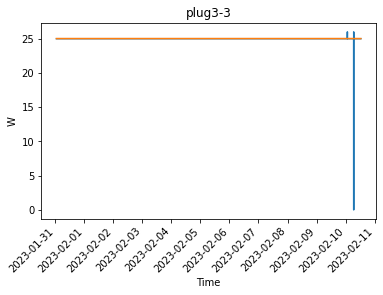

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

mask1 = [i % 5 != 0 for i in range(len(plug1_1))]
y_test = plug1_1[mask1]
y_test = pd.DataFrame(y_test[:-120])

y_test.index = pd.to_datetime(y_test.index, format='"%Y-%m-%d %H:%M:%S"')

# 將y_test轉換為NumPy陣列
y_test_np = y_test.to_numpy()

# 創建x軸數據
x = mdates.date2num(y_test.index)

# 繪製圖表
fig, ax = plt.subplots(facecolor='white')

ax.plot(x, y_test_np)
plt.plot(x,predict_list)

# 設置x軸格式
xfmt = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(xfmt)

# 設置x軸間隔為1天(1440分鐘)
xloc = mdates.MinuteLocator(interval=1440)
ax.xaxis.set_major_locator(xloc)

# 旋轉x軸標籤，以避免擠在一起
fig.autofmt_xdate(rotation=45)

# 設置標籤
plt.xlabel('Time')
plt.ylabel('W')
plt.title('plug3-3')
plt.savefig('/home/awinlab/Documents/kevin/CNN-LSTM/pytorch/CNN-LSTM_plug3-3.png')
plt.show()